In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg as LA
import pywt
import ham_cr

In [2]:
with np.printoptions(precision=4, suppress=True):    
    print(ham_cr.ham_cr_PG_Oh_J_4(1., -0.32))

[[-0.4937  0.      0.      0.     -2.8523  0.      0.      0.      0.    ]
 [ 0.      0.2057  0.      0.      0.     -0.2644  0.      0.      0.    ]
 [ 0.      0.      1.6106  0.      0.      0.      1.3049  0.      0.    ]
 [ 0.      0.      0.     -0.3938  0.      0.      0.     -0.2644  0.    ]
 [-2.8523  0.      0.      0.     -1.8574  0.      0.      0.     -2.8523]
 [ 0.     -0.2644  0.      0.      0.     -0.3938  0.      0.      0.    ]
 [ 0.      0.      1.3049  0.      0.      0.      1.6106  0.      0.    ]
 [ 0.      0.      0.     -0.2644  0.      0.      0.      0.2057  0.    ]
 [ 0.      0.      0.      0.     -2.8523  0.      0.      0.     -0.4937]]


In [3]:
def Jz_op(J):
    mat = np.diag(np.arange(2*J+1,dtype=np.float) - J)
    return mat

def Jplus_op(J):
    mat = np.diag(np.sqrt((2*J - np.arange(2*J))*(np.arange(2*J)+1)), -1)
    return mat

def Jminus_op(J):
    mat = np.diag(np.sqrt((2*J - np.arange(2*J))*(np.arange(2*J)+1)), 1)
    return mat

def Jx_op(J):
    mat = (Jplus_op(J) + Jminus_op(J))/2.
    return mat

def Jy_op(J):
    mat = -1j/2.*(Jplus_op(J) - Jminus_op(J))
    return mat
    
# with np.printoptions(precision=4, suppress=True):
#     print(Jx_op(4))

In [4]:
def specific_heat(ham, T_min=1, T_max=51, T_steps=500):
    """
    Returns array of specific heat over temperature range [T_min, T_max] for hamiltonian matrix ham

    Parameters: 
        ham : hermitian Hamiltonian matrix, typically of crystal field Hamiltonian (dimension 2*J+1)
        T_min : minimal temperature in Kelvin
        T_max : maximal temprature in Kelvin
        T_steps: total number of steps in temperature range

    Returns: 
        cV: specific heat array of dimension (T_steps, 2) containing (T_i, specific_heat(T_i) ), where T_i is temperature at step i 

    """  
    T = np.linspace(T_min, T_max, T_steps)
    energies = LA.eigvalsh(ham)
    energies = energies - energies[0]

    def Z_cr(T):
        return np.sum(np.exp(-energies/T))
    
    def cV(T):
        return 1./(T**2) * (np.sum(energies**2 * np.exp(-energies/T))/Z_cr(T) - np.sum(energies * np.exp(-energies/T)/Z_cr(T))**2)

    cV_array = np.zeros((len(T), 2))

    # this can probably be optimized using numpy ufuncs, but it is ok for now
    for i in range(0, len(cV_array)):
        cV_array[i][0] = T[i]
        cV_array[i][1] = cV(T[i])
  
    return cV_array

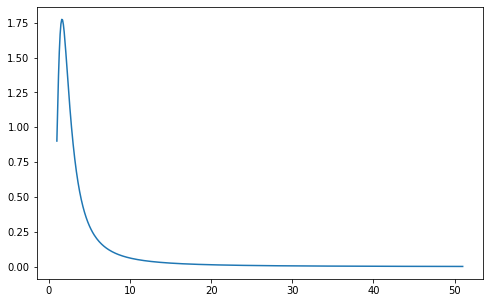

In [5]:

cV_data = specific_heat(ham_cr.ham_cr_PG_Oh_J_4(1., -0.32))
T = cV_data[:, 0]
cV = cV_data[:, 1]

fig = plt.figure(1, figsize = [8,5])
ax = plt.plot(T, cV)
plt.show()

In [46]:
def magnetization(ham_cr, B_direction, B_min=0, B_max=10, B_steps=1, T_min=1, T_max=300, T_steps=4, J=4, L=5, S=1):
    """
    Returns array of magnetization over temperature and magnetic field range [T_min, T_max] and [B_min, B_max] for a system with zero-field Hamiltonian matrix ham_cr. The magnetic field is along B_direction (x, y, z).  
    Parameters: 
        ham_cr : hermitian Hamiltonian matrix in zero field, typically of crystal field Hamiltonian (dimension 2*J+1)
        B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
        B_min: minimal field (in Tesla)
        B_max: maximal field (in Tesla)
        B_steps: total number of steps in field range
        T_min : minimal temperature in Kelvin
        T_max : maximal temprature in Kelvin
        T_steps: total number of steps in temperature range
        J, L, S: determine the g-factor (using LS coupling scheme)

    Returns: 
        mag: magnetization array of dimension (T_steps, B_steps, 2) containing (T_i, B_i, specific_heat(T_i) ), where T_i (B_i) is temperature (field) at step i 

    """  
    muB_over_kB = 0.671713816
    gJLS = 0.8 # eventually make LS formula depending on J, L, S

    T_array = np.geomspace(T_min, T_max, T_steps)
    B_array = np.linspace(B_min, B_max, B_steps)

    B_direction = B_direction/LA.norm(B_direction)
    J_op = B_direction[0]*Jx_op(J) + B_direction[1]*Jy_op(J) + B_direction[2]*Jz_op(J)

    mag_array = np.zeros((len(B_array), len(T_array), 3))

    # this can probably be optimized using numpy ufuncs, but it is ok for now
    
    for B_idx in np.arange(0, len(B_array)):
        B = B_array[B_idx]
        ham = ham_cr - gJLS*muB_over_kB*J_op*B
        energies, eigenstates = LA.eigh(ham)
        energies = energies - energies[0]
        
        for T_idx in range(0, len(T_array)):
            T = T_array[T_idx]
            ZB = np.sum(np.exp(-energies/T))
            mag = 1/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])
   
            mag_array[B_idx][T_idx][0] = B_array[B_idx]
            mag_array[B_idx][T_idx][1] = T_array[T_idx]
            mag_array[B_idx][T_idx][2] = mag

    return mag_array

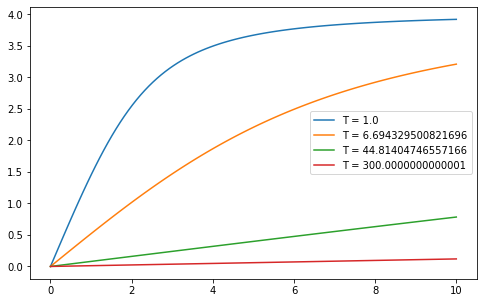

In [47]:
mag_data = magnetization(ham_cr.ham_cr_PG_Oh_J_4(1., -0.32), [0,0,1], B_steps = 100)
B1 = mag_data[:, 0, 0]
mag1 = mag_data[:, 0, 2]
B2 = mag_data[:, 1, 0]
mag2 = mag_data[:, 1, 2]
B3 = mag_data[:, 2, 0]
mag3 = mag_data[:, 2, 2]
B4 = mag_data[:, 3, 0]
mag4 = mag_data[:, 3, 2]

fig = plt.figure(1, figsize = [8,5])
ax = plt.plot(B1, mag1, label='T = '+str(mag_data[0, 0, 1]))
ax = plt.plot(B2, mag2, label='T = '+str(mag_data[0, 1, 1]))
ax = plt.plot(B3, mag3,  label='T = '+str(mag_data[0, 2, 1]))
ax = plt.plot(B4, mag4,  label='T = '+str(mag_data[0, 3, 1]))
ax = plt.legend()


plt.show()

In [77]:
np.arange(1)+1

array([1])

In [18]:
print(mag_data)

[[[1.00000000e+00 1.00000000e+00 1.50686778e+00]
  [1.00000000e+00 6.69432950e+00 2.18455253e+00]
  [1.00000000e+00 4.48140475e+01 6.34795497e-01]
  [1.00000000e+00 3.00000000e+02 1.05467142e-01]]

 [[1.09090909e+00 1.00000000e+00 1.63048240e+00]
  [1.09090909e+00 6.69432950e+00 2.36285153e+00]
  [1.09090909e+00 4.48140475e+01 6.91403502e-01]
  [1.09090909e+00 3.00000000e+02 1.15026938e-01]]

 [[1.18181818e+00 1.00000000e+00 1.75051930e+00]
  [1.18181818e+00 6.69432950e+00 2.53630296e+00]
  [1.18181818e+00 4.48140475e+01 7.47737100e-01]
  [1.18181818e+00 3.00000000e+02 1.24579669e-01]]

 ...

 [[9.81818182e+00 1.00000000e+00 3.92430689e+00]
  [9.81818182e+00 6.69432950e+00 5.40255157e+00]
  [9.81818182e+00 4.48140475e+01 4.44649982e+00]
  [9.81818182e+00 3.00000000e+02 9.81187370e-01]]

 [[9.90909091e+00 1.00000000e+00 3.92560669e+00]
  [9.90909091e+00 6.69432950e+00 5.39248463e+00]
  [9.90909091e+00 4.48140475e+01 4.47079508e+00]
  [9.90909091e+00 3.00000000e+02 9.89651726e-01]]

 [[1

SyntaxError: invalid syntax (<ipython-input-33-87ea02d8f277>, line 2)

In [71]:
print(mag_data[:,0,0])

[ 1.          1.09090909  1.18181818  1.27272727  1.36363636  1.45454545
  1.54545455  1.63636364  1.72727273  1.81818182  1.90909091  2.
  2.09090909  2.18181818  2.27272727  2.36363636  2.45454545  2.54545455
  2.63636364  2.72727273  2.81818182  2.90909091  3.          3.09090909
  3.18181818  3.27272727  3.36363636  3.45454545  3.54545455  3.63636364
  3.72727273  3.81818182  3.90909091  4.          4.09090909  4.18181818
  4.27272727  4.36363636  4.45454545  4.54545455  4.63636364  4.72727273
  4.81818182  4.90909091  5.          5.09090909  5.18181818  5.27272727
  5.36363636  5.45454545  5.54545455  5.63636364  5.72727273  5.81818182
  5.90909091  6.          6.09090909  6.18181818  6.27272727  6.36363636
  6.45454545  6.54545455  6.63636364  6.72727273  6.81818182  6.90909091
  7.          7.09090909  7.18181818  7.27272727  7.36363636  7.45454545
  7.54545455  7.63636364  7.72727273  7.81818182  7.90909091  8.
  8.09090909  8.18181818  8.27272727  8.36363636  8.45454545  8.545

In [ ]:
class training_data_generation():
    

In [44]:
dg = data_generation()

NameError: name 'data_generation' is not defined

In [8]:
class data_generation:
    # Magnetizations M and magnetizations squared M2 below correspond to the energy levels above
    M = [0, 0, 0, -0.5, 0.5, 0, 2.5, -2.5, 0]
    M2 = [(0.4564**2)*(4*5)*2, (0.5401**2)*(4*5)*2, (0.7071**2)*(2*3)*2, 
          (0.3536**2)*(3*4) + (0.9354**2)*(1*2), (0.3536**2)*(3*4) + 
          (0.9354**2)*(1*2), (0.7071**2)*(4*5)*2, (0.9354**2)*(3*4) +
          (0.3536**2)*(1*2), (0.9354**2)*(3*4) + (0.3536**2)*(1*2),
          (0.7071**2)*(2*3)*2]
    
    
    # Matrix that expresses the Gamma1, Gamma3, Gamma4, and Gamma5 
    # states in terms of Jz eigenstates whereJZ states are ordered by eigenvalue in descending order
    CFinJzbasis = np.matrix([[np.sqrt(5/24.), 0, 0, 0, np.sqrt(7/12.), 0, 0, 0, np.sqrt(5/24.)],
                            [np.sqrt(7/24.), 0, 0, 0, -np.sqrt(5/12.), 0, 0, 0, np.sqrt(7/24.)],
                            [0, 0, np.sqrt(1/2.), 0, 0, 0, np.sqrt(1/2.), 0, 0],
                            [0, np.sqrt(1/8.), 0, 0, 0, np.sqrt(7/8.), 0, 0, 0],
                            [0, 0, 0, np.sqrt(7/8.), 0, 0, 0, np.sqrt(1/8.), 0],
                            [-np.sqrt(1/2.), 0, 0, 0, 0, 0, 0, 0, np.sqrt(1/2.)],
                            [0, np.sqrt(7/8.), 0, 0, 0, -np.sqrt(1/8.), 0, 0, 0],
                            [0, 0, 0, -np.sqrt(1/8.), 0, 0, 0, np.sqrt(7/8.), 0],
                            [0, 0, -np.sqrt(1/2.), 0, 0, 0, np.sqrt(1/2.), 0, 0]])
    
    #Contribution of the magnetic field to the Hamiltonian
    mag_field = np.diag([4, 3, 2, 1, 0, -1, -2, -3, -4])
    CFinJzbasis_inv = LA.inv(CFinJzbasis)
    
    # Boltzmann constant. Since I am measuring everything in units of temperature it is set to 1
    kb = 1
    
    
    def beta(self, T):
        """
        Inverse temperature, rather useful to define in statistical physics     
        
        Args:
            T: Temperature in Kelvin   
        Returns:
            Inverse temperature    
        """
        return 1 / (self.kb * T)
    
    
    def generate_heat_data(self, data):
        """
        Expression for specific heat
        
        Args:
            data: Array of energy levels
        Returns:
            s_heat: Array of specific heat values from 1K-100K at a given step size
        """
        # Parse energy levels
        # el = self.format_data(data)
        el = data
        # Can change once we have Stephen's operators
        mul = [1,2,3,3]
        s_heat = []
        
        # Specific heat derived from second derivative of partition function, simplified. Took straight from Mathematica
        def c(T):
            if (len(el) != len(mul)):
                raise ValueError("Levels and multiplicity don't have same length")
            numer = lambda T: np.sum(np.sum([[(mul[i] * mul[j-1]) * np.exp(-(el[i] + el[j-1])/T) * (el[i] - el[j-1])**2 for j in range(len(el), i+1, -1)] for i in range(len(el)-1)]))
            denom = lambda T: (np.sum([mul[i]*np.exp(-el[i] * self.beta(T)) for i in range(len(el))])**2) * T**2
            return numer(T)/denom(T)
                
        # Change max temperature and step size
        temp = 200
        step = 2 
        for j in range(0, temp, step):
            s_heat.append(c(j+1))  
        return s_heat
    
    
    def generate_susc_data(self, data):
        """
        Expression for susceptibility
        
        Args:
            data: Array of energy levels
        Returns:
            susc: Array of susceptibility values from 1K-100K at a given step size
        """
        energyLevel = self.format_data(data)
        susc = []
        
        #Magnetic field is 1/1000th of the smallest energy differences
        B = min([abs(data[1]), abs(data[2]), abs(data[3]), abs(data[1]-data[2]), abs(data[2]-data[3]), abs(data[1]-data[3])])/1000        
        #Crystal field Hamiltonian (ie the original energy levels)
        HamCF = np.diag(energyLevel)
        #Contribution of the magnetic field to the Hamiltonian
        HamB = B * self.mag_field
        #Total Hamiltonian
        HamCFandB = (self.CFinJzbasis_inv @ HamCF @ self.CFinJzbasis) - HamB 
        #Solving the eigenvalue problem
        Eigenvals, Eigenvecs = LA.eigh(HamCFandB)
        #Calculating the magnetization for each eigenvector
        Jz = []
        for x in range(9):
            Jz.append(np.sum([i*np.conj(i)*(5-(j+1)) for i,j in zip(Eigenvecs[:,x], range(len(Eigenvecs[:,x])))]))
        #Partition function in field
        ZinB = lambda T : np.sum([np.exp(-i * self.beta(T)) for i in Eigenvals])
        
        MexpinB = lambda T: (np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))
        chi = lambda T: abs(MexpinB(T)) / B
        
        # Change max temperature and step size
        temp = 200
        step = 2
        for j in range(0, temp, step):
            susc.append(chi(j+1))
        return susc
    
    
    def generate_mag_data(self, data):
        """
        Expression for magnetization
        
        Args:
            data: Array of energy levels
        Returns:
            MexpinBLowT: Array of magnetization values from 1T-10T at T=1.0
            MexpinBMidT: Array of magnetization values from 1T-10T at T=100.0
            MexpinBHighT: Array of magnetization values from 1T-10T at T=299.0
        """
        energyLevel = self.format_data(data)
        MexpinBLowT = []
        MexpinBMidT = []
        MexpinBHighT = []
        
        #Magnetization data collected at 3 temperatures: T=1, 150, and 299 Kelvin
        #Magnetic field is varied from 1T to 10T in units of 0.2T (0.185T to get 50 datapoints)
        nparr = np.arange(1*0.5373712344398849, 10*0.5473712344398849, 0.092*0.5373712344398849)
        for B in nparr:
            #Crystal field Hamiltonian (ie the original energy levels)
            HamCF = np.diag(energyLevel)
            #Contribution of the magnetic field to the Hamiltonian
            HamB = B * self.mag_field
            #Total Hamiltonian
            HamCFandB = (self.CFinJzbasis_inv @ HamCF @ self.CFinJzbasis) - HamB
            #Solving the eigenvalue problem
            Eigenvals, Eigenvecs = LA.eigh(HamCFandB)
            #Calculating the magnetization for each eigenvector
            Jz = []
            for x in range(9):
                Jz.append(np.sum([i*np.conj(i)*(5-(j+1)) for i,j in zip(Eigenvecs[:,x], range(len(Eigenvecs[:,x])))]))
            #Partition function in field
            ZinB = lambda T : np.sum([np.exp(-i * self.beta(T)) for i in Eigenvals])
            
            T = 1.0
            #Expectation value of the magnetization in field
            MexpinBLowT.append(np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))
            
            T = 150.0
            #Expectation value of the magnetization in field
            MexpinBMidT.append(np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))

            T = 299.0
            #Expectation value of the magnetization in field
            MexpinBHighT.append(np.sum([i * np.exp(-j * self.beta(T)) for i,j in zip(Jz, Eigenvals)]) / ZinB(T))

        return (MexpinBLowT, MexpinBMidT, MexpinBHighT)
    
    
    def format_data(self, energyLevels):
        """
        Function to create energy levels matrix
        
        Args:
            energyLevels: Array of energy levels
        Returns:
            data: Formatted array of energy levels with a length of 9        
        """
        data = []
        if (len(energyLevels) == 4):
            data = [energyLevels[0],energyLevels[1],energyLevels[1],energyLevels[2],energyLevels[2],energyLevels[2],energyLevels[3],energyLevels[3],energyLevels[3]]
        elif (len(energyLevels) == 3):
            data = [0,energyLevels[0],energyLevels[0],energyLevels[1],energyLevels[1],energyLevels[1],energyLevels[2],energyLevels[2],energyLevels[2]]
        elif (len(energyLevels) == 9):
            data = energyLevels
        return data
    
    
################################### Automatic Data Generation  ###################################

    def generate_energy_levels(self, num):
        """
        Generate num number of energy levels sets.
        E0 is set to 0. E3, E4, and E5 are the differences between E0 and the next levels.
        
        Args:
            num: Number of energy levels sets to generate
        Returns:
            energyLevels: Array of energy levels   
        """
        E1 = 0
        energyLevels = []
        for i in range(num):
            E3 = np.random.uniform(low=-75.0, high=75.0)
            E4 = np.random.uniform(low=-75.0, high=75.0)
            E5 = np.random.uniform(low=-75.0, high=75.0)
            new_target = [E1, E3, E4, E5]
            energyLevels.append(new_target)
        return energyLevels

    
    def generate_data(self, num):
        """
        Generate num number of energy level sets.
        Also generate susceptibility, specific heat, and magnetization data.
        
        Args:
            num: Number of examples to generate
        Returns:
            eLs: Array of energy levels
            data: Array of specific heat, susceptibility, and magnetization data, in that order
        """
        eLs = self.generate_energy_levels(num)
        data = []
        
        for i in range(len(eLs)):
            row = []
            row = self.generate_heat_data(eLs[i]) + self.generate_susc_data(eLs[i])
           
            low, mid, high = dg.generate_mag_data(eLs[i])
            row = row + np.asarray(low).ravel().tolist()
            row = row + np.asarray(mid).ravel().tolist()
#             row = row + np.asarray(high).ravel().tolist()

            if (i % 1000 == 0):
                print('{} training examples generated'.format(i))
            data.append(row)
            
        return (eLs, data)
        
##################################################################################################

In [6]:
#[E3, E4, E5]
# energyLevels = [0, -7.868318060081819, 5.214400228782935, -51.170630907172594]
energyLevels = [0, np.random.uniform(low=-75.0, high=75.0), np.random.uniform(low=-75.0, high=75.0), np.random.uniform(low=-75.0, high=75.0)]

print('E1: {}'.format(energyLevels[0]))
print('E3: {}'.format(energyLevels[1]))
print('E4: {}'.format(energyLevels[2]))
print('E5: {}'.format(energyLevels[3]))

E1: 0
E3: 20.5975496154075
E4: -57.043207692213976
E5: -27.56652854724554


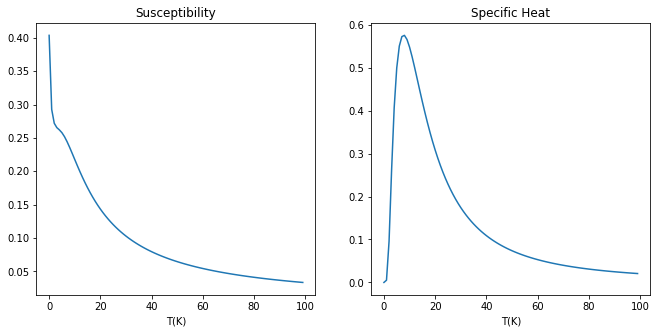

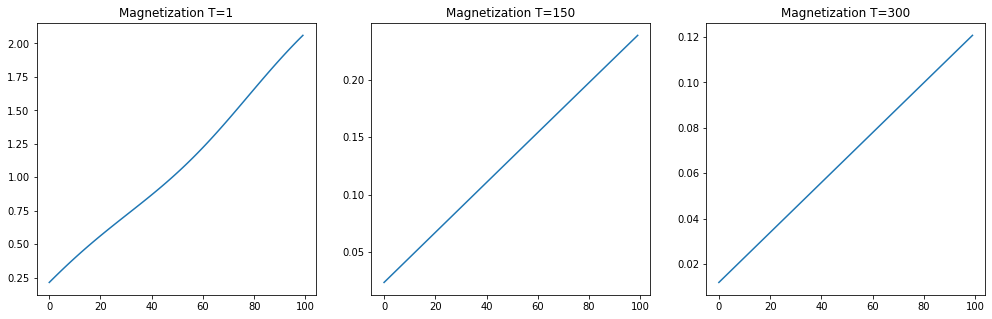

In [7]:
#Generating susceptibility, specific heat, and magnetization data
susc = dg.generate_susc_data(energyLevels)
susc = pd.DataFrame(np.asarray(susc).ravel())
s_heat = pd.DataFrame(dg.generate_heat_data(energyLevels))

fig, (ax, ax2) = plt.subplots(ncols=2)
susc_plot = susc.plot(figsize=(11,5), title='Susceptibility', legend=False, ax=ax)
susc_plot.set_xlabel('T(K)')
s_heat_plot = s_heat.plot(figsize=(11,5),title='Specific Heat', legend=False, ax=ax2)
s_heat_plot.set_xlabel('T(K)')
plt.show()

low, mid, high = dg.generate_mag_data(energyLevels)
low_mag = pd.DataFrame(np.asarray(low).ravel())
mid_mag = pd.DataFrame(np.asarray(mid).ravel())
high_mag = pd.DataFrame(np.asarray(high).ravel())

fig2, (ax3, ax4, ax5) = plt.subplots(ncols=3, figsize=(17, 5))
low_mag_plot = low_mag.plot(title='Magnetization T=1', legend=False, ax=ax3)
mid_mag_plot = mid_mag.plot(title='Magnetization T=150', legend=False, ax=ax4)
high_mag_plot = high_mag.plot(title='Magnetization T=300', legend=False, ax=ax5)
plt.show()

In [84]:
print(pywt.wavelist(kind='continuous'))
#gaus2
#morl

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


<Figure size 432x288 with 0 Axes>

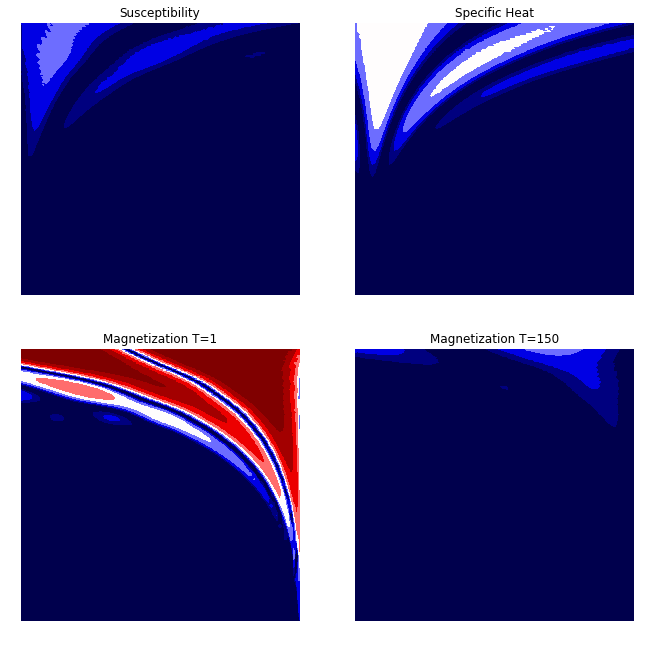

In [88]:
time = np.arange(1,101)
scale = np.arange(1,101)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)
wave = 'morl'

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

[susc_coeff, susc_freq] = pywt.cwt(susc.squeeze(), scale, wave, 1)
susc_power = (abs(susc_coeff)) ** 2
susc_period = 1. / susc_freq

[sheat_coeff, sheat_freq] = pywt.cwt(s_heat.squeeze(), scale, wave, 1)
sheat_power = (abs(sheat_coeff)) ** 2
sheat_period = 1. / sheat_freq

[low_coeff, low_freq] = pywt.cwt(low_mag.squeeze(), scale, wave, 1)
low_power = (abs(low_coeff)) ** 2
low_period = 1. / low_freq
 
[mid_coeff, mid_freq] = pywt.cwt(mid_mag.squeeze(), scale, wave, 1)
mid_power = (abs(mid_coeff)) ** 2
mid_period = 1. / mid_freq
 
[hig_coeff, hig_freq] = pywt.cwt(high_mag.squeeze(), scale, wave, 1)
hig_power = (abs(hig_coeff)) ** 2
hig_period = 1. / hig_freq

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(11,11))
susc_plot = ax[0,0].contourf(time, np.log2(susc_period), np.log2(susc_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[0,0].set_title('Susceptibility')
ax[0,0].axis('off')
sheat_plot = ax[0,1].contourf(time, np.log2(sheat_period), np.log2(sheat_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[0,1].set_title('Specific Heat')
ax[0,1].axis('off')

low_mag_plot = ax[1,0].contourf(time, np.log2(low_period), np.log2(low_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[1,0].set_title('Magnetization T=1')
ax[1,0].axis('off')
mid_mag_plot = ax[1,1].contourf(time, np.log2(mid_period), np.log2(mid_power), contourlevels, extend='both',cmap=plt.cm.seismic)
ax[1,1].set_title('Magnetization T=150')
ax[1,1].axis('off')
#hig_mag_plot = ax5.contourf(time, np.log2(hig_period), np.log2(hig_power), contourlevels, extend='both',cmap=plt.cm.seismic)
plt.savefig('cwt.png', bbox_inches='tight')
plt.show()


In [86]:
# els = ['e1','e3','e4','e5']
# mul = [1,2,3,3]
# for i in range(len(els)-1):
#     for j in range(len(els),i+1,-1):
#         print(str(i) + str(j-1))
#         print(els[i] + els[j-1])
#         (mul[i] * mul[j-1]) * np.exp(-(els[i] + els[j-1])/beta(T)) * (els[i] - els[j-1])**2
#     print("\n")

In [8]:
targets, data = dg.generate_data(1)
targets_df = pd.DataFrame(targets)
data_df = pd.DataFrame(data)
targets_df.to_csv('generated_targets_1.csv', header=None, index=None)
data_df.to_csv('generated_data_1.csv', header=None, index=None)

0 training examples generated


In [46]:
# http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

# x axis is time (temperature or magnetization)
# y axis is period (1 / frequency) 
# color is power (related to the cwt coefficients)

# scale is related to how detailed different frequencies can be